In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.utils as ku
import tensorflow as tf
import numpy as np
import re

In [26]:
tokenizer = Tokenizer()

data = open('fellowship-songs.txt').read()

data = data.replace(',', ' pausesentence')
data = data.replace('!', ' exclamationmark')
data = data.replace('.', 'endofthesentence')
data = data.replace('?', 'questionmark')

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [30]:
len(corpus), len(tokenizer.word_index)#, tokenizer.word_counts

(519, 1080)

In [31]:
model = Sequential()

model.add(Embedding(1080, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(40, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 13, 64)            69120     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 13, 40)            13600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 40)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 40)                9760      
_________________________________________________________________
dense_10 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_11 (Dense)             (None, 1081)              44321     
Total params: 138,441
Trainable params: 138,441
Non-trainable params: 0
_________________________________________________________________
None

In [32]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
3150/3150 [==============================] - 13s 4ms/step - loss: 6.5053 - acc: 0.0467
Epoch 2/100
3150/3150 [==============================] - 5s 2ms/step - loss: 5.9555 - acc: 0.0708
Epoch 3/100
3150/3150 [==============================] - 5s 2ms/step - loss: 5.8748 - acc: 0.0717
Epoch 4/100
3150/3150 [==============================] - 5s 1ms/step - loss: 5.7690 - acc: 0.0724
Epoch 5/100
3150/3150 [==============================] - 5s 1ms/step - loss: 5.6737 - acc: 0.0781
Epoch 6/100
3150/3150 [==============================] - 5s 1ms/step - loss: 5.5608 - acc: 0.0835
Epoch 7/100
3150/3150 [==============================] - 4s 1ms/step - loss: 5.4719 - acc: 0.0863
Epoch 8/100
3150/3150 [==============================] - 4s 1ms/step - loss: 5.3672 - acc: 0.0956
Epoch 9/100
3150/3150 [==============================] - 5s 2ms/step - loss: 5.2844 - acc: 0.1003
Epoch 10/100
3150/3150 [==============================] - 5s 2ms/step - loss: 5.2003 - acc: 0.0994
Epoch 11/100
3150/

3150/3150 [==============================] - 5s 1ms/step - loss: 1.9682 - acc: 0.4927
Epoch 84/100
3150/3150 [==============================] - 4s 1ms/step - loss: 2.0018 - acc: 0.4803
Epoch 85/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.9686 - acc: 0.4857
Epoch 86/100
3150/3150 [==============================] - ETA: 0s - loss: 1.9128 - acc: 0.495 - 5s 1ms/step - loss: 1.9124 - acc: 0.4952
Epoch 87/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.8948 - acc: 0.4956A: 
Epoch 88/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.8367 - acc: 0.5257
Epoch 89/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.8308 - acc: 0.5194
Epoch 90/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.8398 - acc: 0.5229
Epoch 91/100
3150/3150 [==============================] - 5s 1ms/step - loss: 1.8222 - acc: 0.5190
Epoch 92/100
3150/3150 [==============================] - 5s 1ms/step - loss: 1.7

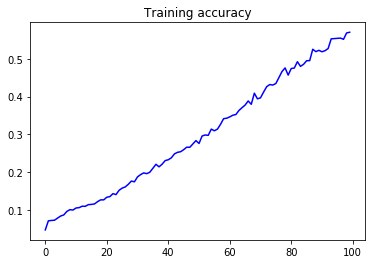

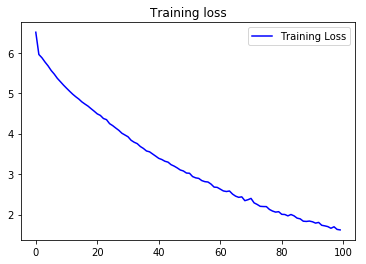

In [33]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [34]:
seed_text = "O"
next_words = 500
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            if output_word == 'endofthesentence':
                output_word = '.'
            break
    seed_text += " " + output_word
    
seed_text = seed_text.replace('endofthesentence', '.')
seed_text = seed_text.replace('questionmark', '?')
seed_text = seed_text.replace(' pausesentence', ',')
seed_text = seed_text.replace(' exclamationmark', '!')
seed_text = seed_text.replace('endofline', '\n')

rtn = re.split('([.!?] *)', seed_text)
seed_text = ''.join([each.capitalize() for each in rtn])

count_sentences = 0
for i in range(len(seed_text)):
    if seed_text[i] == '\n':
        count_sentences += 1
        if count_sentences%5 == 0:  
            seed_text = seed_text[:i] + '\n\n' + seed_text[i+1:].strip()

print(seed_text)

O galadriel! Water hot is laid, tom bombadillo! Sing! Darling!! O! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darling!! O! Darling!! Darling!! Darling!! O, withywindle!! Darling!! Darling!! Darlin

In [25]:
model.load_weights("model_for_song.h5")

ValueError: Shapes (40, 1158) and (40, 1081) are incompatible

In [10]:
#model.save_weights("model_for_song.h5")